Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


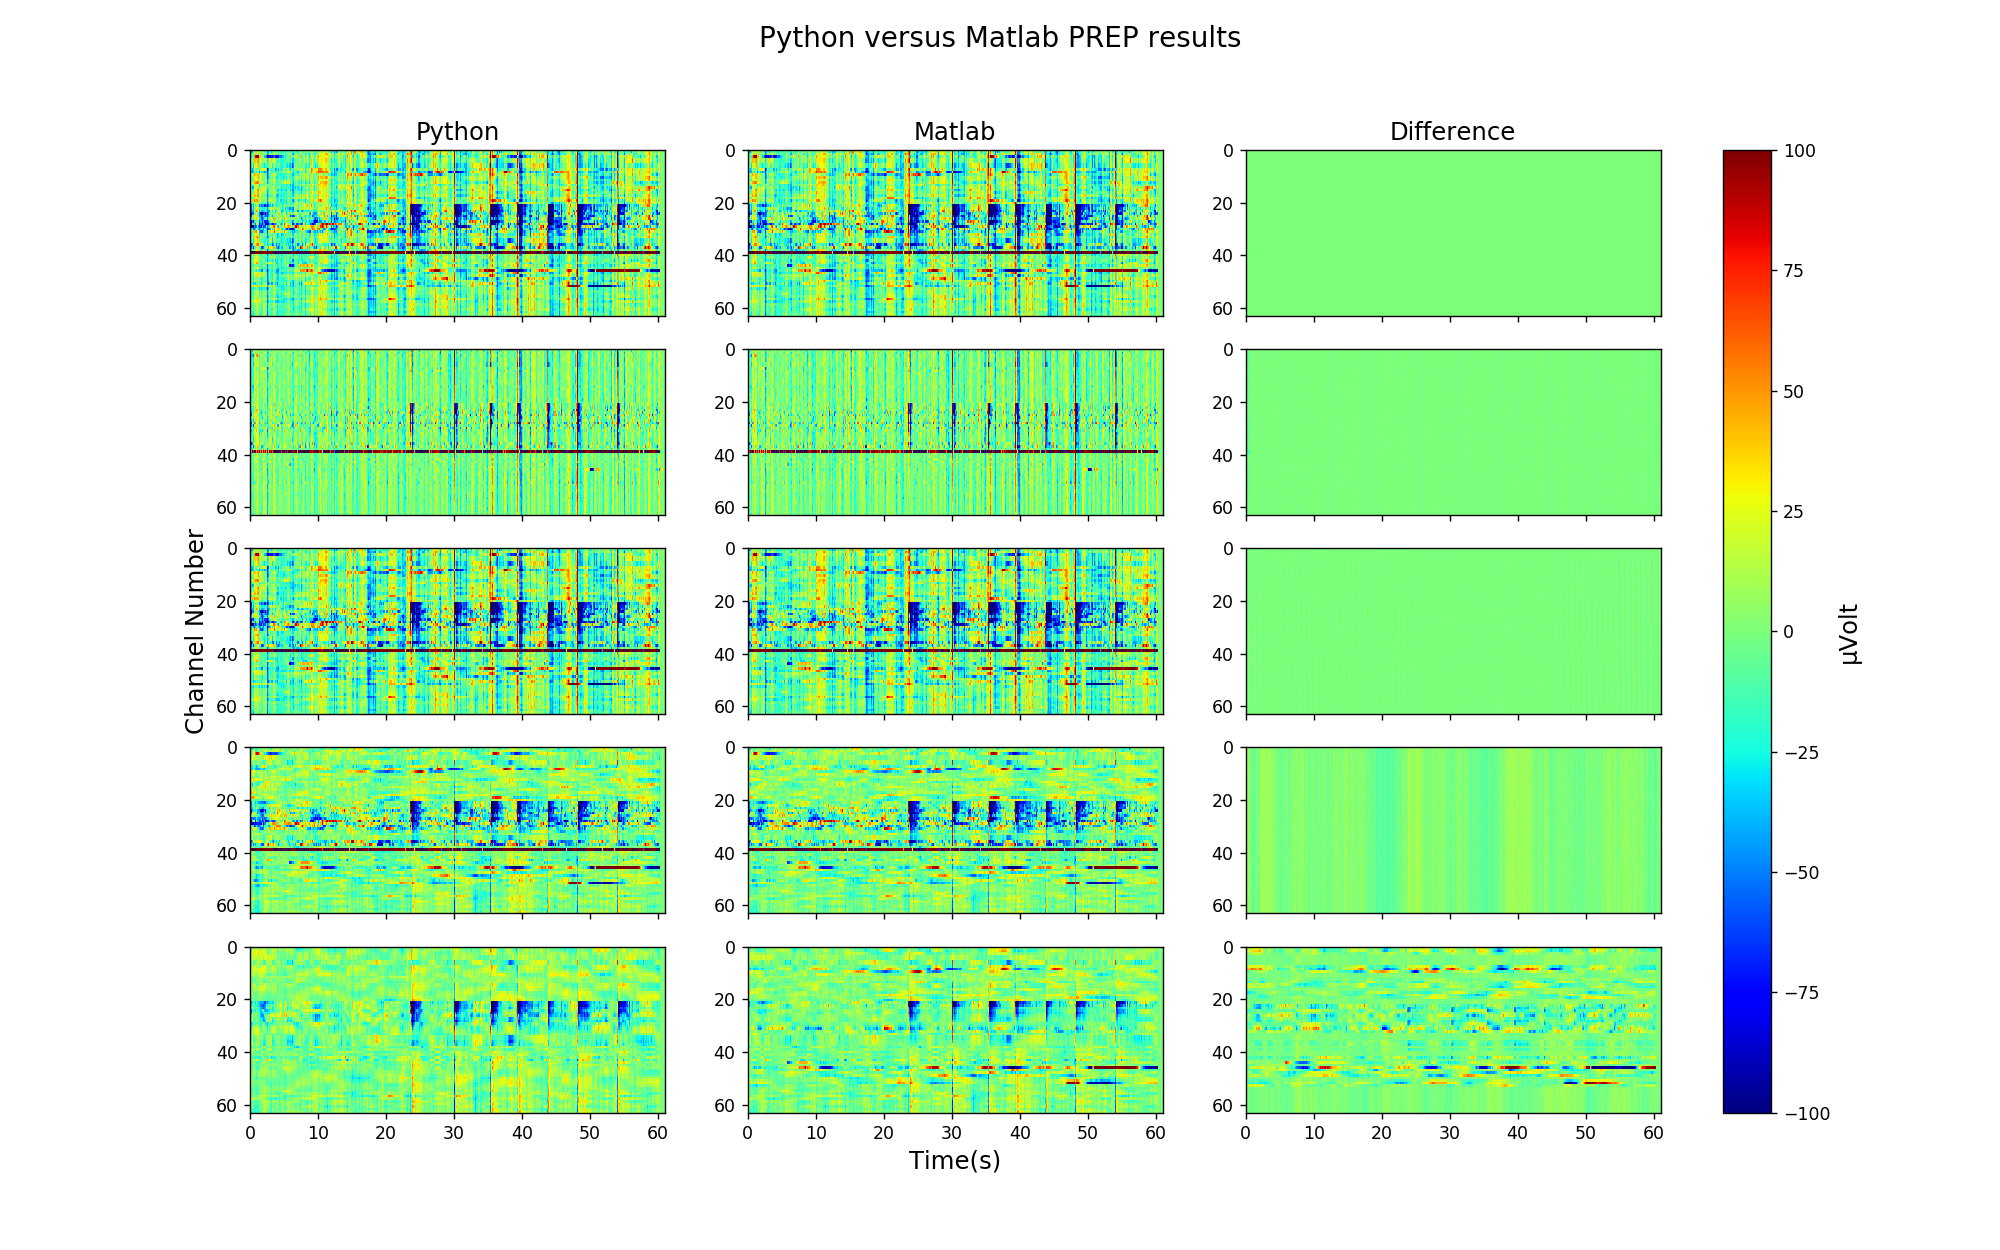

2019-12-06 03:46:28,304 - reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['Af8', 'Ft8'], 'bad_by_hf_noise': ['Af3', 'Af8', 'Fp1', 'Fpz', 'Fp2', 'Af3', 'Af4', 'Af8'], 'bad_by_correlation': ['Af7', 'Af3', 'Af4', 'Af8', 'F8', 'Ft8', 'T10'], 'bad_by_ransac': ['F8', 'Ft8'], 'bad_all': ['Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Af4', 'Af8', 'F8', 'Ft8', 'T10']}
2019-12-06 03:46:30,472 - reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['Ft8', 'Af8'], 'bad_by_hf_noise': ['Af4', 'Fpz', 'Af3', 'Af8', 'Fp2', 'Fp1'], 'bad_by_correlation': ['Af4', 'Cp5', 'P2', 'Cp6', 'F7', 'P7', 'Ft8', 'Fp1', 'Cp3', 'Afz', 'F3', 'F1', 'Tp7', 'Fpz', 'F5', 'C4', 'Fc5', 'C3', 'Af3', 'Af8', 'Fp2', 'F8', 'C5', 'F6', 'T10', 'Cp4', 'Af7'], 'bad_by_ransac': ['Af4', 'Cp5', 'P2', 'Cp6', 'F7', 'P7', 'Ft8', 'Fp1', 'Cp3', 'F3', 'Tp7', 'Fpz', 'F5', 'C4', 'Fc5', 'C3', 'Af3', 'Af8', 'Fp2', 'F8', 'C5', 'F6', 'Cp4', 'Af7', 'Fc3'], 'bad_all': ['Af4', 'Cp

Found 36 uniquely bad channels.

0 by n/a: []

0 by flat: []

1 by deviation: ['Ft8']

0 by hf noise: []

25 by correl: ['Fc5', 'Fc3', 'Fc1', 'C5', 'C4', 'C6', 'Cp3', 'Cp4', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'F6', 'F8', 'Ft8', 'Tp7', 'Tp8', 'P3', 'P2']

0 by SNR []

0 by dropout: []

33 by ransac: ['Fc5', 'Fc3', 'Fc1', 'C5', 'C3', 'C1', 'C4', 'C6', 'Cp5', 'Cp3', 'Cpz', 'Cp2', 'Cp4', 'Af7', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'F6', 'F8', 'Ft8', 'T9', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'P2', 'P4', 'P6']


In [4]:
%pylab nbagg
import mne
import scipy.io as sio

import matplotlib.pyplot as plt
from noisy import Noisydata
from reference import robust_reference, remove_reference
from utilities import union, set_diff
from removeTrend import removeTrend
from find_noisy_channels import NoisyChannels

mne.set_log_level("WARNING")

raw = mne.io.read_raw_edf("D:/JHU/NDD/Motor Imagery Data/S004R01.edf", preload=True)
raw.rename_channels(lambda s: s.strip("."))
# raw = mne.io.read_raw_eeglab('D:/JHU/NDD/eeglab-master/sample_data/eeglab_data.set',
#                              eog='auto', preload=True)

# Set montage
montage_kind = "standard_1020"
# montage_kind = "D:/JHU/NDD/eeglab-master/sample_locs/GSN129.sfp"
# montage_kind = 'GSN-HydroCel-129'
# montage_kind = 'D:/JHU/NDD/eeglab-master/sample_data/eeglab_chan32.locs'
montage = mne.channels.read_montage(montage_kind, ch_names=raw.info['ch_names'])
raw.set_montage(montage)

eeg_index = mne.pick_types(raw.info, eeg=True, eog=False, meg=False)
eog_index = mne.pick_types(raw.info, eeg=False, eog=True, meg=False)

raw_copy = raw.copy()
ch_names = raw_copy.info["ch_names"]
ch_names_eeg = list(np.asarray(ch_names)[eeg_index])
sample_rate = raw_copy.info["sfreq"]
# Set PREP parameters
prep_params = {'ref_chs': ch_names_eeg, 'eval_chs': ch_names_eeg,
               'reref_chs': ch_names_eeg, 'line_freqs': 60}

# noisy_detector = Noisydata(raw_copy, montage_kind=montage_kind)
noisy_detector = NoisyChannels(raw_copy)
# noisy_detector.find_bad_by_nan()
# noisy_detector.find_bad_by_flat()
noisy_detector.find_bad_by_nan_flat()
unusable_channels = union(noisy_detector.bad_by_nan, noisy_detector.bad_by_flat)
reference_channels = set_diff(prep_params['ref_chs'], unusable_channels)

EEG_raw = raw_copy.get_data(picks='eeg')*1e6
EEG_raw_matlab = sio.loadmat('D:/JHU/NDD/EEGdata_tmp/EEG_raw.mat')
EEG_raw_matlab = EEG_raw_matlab['save_data']
EEG_raw_diff = EEG_raw - EEG_raw_matlab
EEG_raw_mse = (EEG_raw_diff**2).mean(axis=None)

fig, axs = plt.subplots(5, 3, 'all', figsize=[16,10])
plt.setp(fig, facecolor=[1, 1, 1])
fig.suptitle('Python versus Matlab PREP results', fontsize=16)

im = axs[0, 0].imshow(EEG_raw, aspect='auto', extent=[0, (EEG_raw.shape[1] / sample_rate), 63, 0],
                      vmin=-100, vmax=100, cmap='jet')
axs[0, 0].set_title('Python', fontsize=14)
axs[0, 1].imshow(EEG_raw_matlab, aspect='auto', extent=[0, (EEG_raw_matlab.shape[1] / sample_rate), 63, 0],
                      vmin=-100, vmax=100, cmap='jet')
axs[0, 1].set_title('Matlab', fontsize=14)
axs[0, 2].imshow(EEG_raw_diff, aspect='auto', extent=[0, (EEG_raw_diff.shape[1] / sample_rate), 63, 0],
                      vmin=-100, vmax=100, cmap='jet')
axs[0, 2].set_title('Difference', fontsize=14)
# axs[0, 0].set_title('Original EEG', loc='left', fontsize=14)
# axs[0, 0].set_ylabel('Channel Number', fontsize=14)
cb = fig.colorbar(im, ax=axs, fraction=0.05, pad=0.04)
cb.set_label('\u03BCVolt', fontsize=14)

# Step 1: 1Hz high pass filtering
EEG_new_matlab = sio.loadmat('D:/JHU/NDD/EEGdata_tmp/EEGNew.mat')
EEG_new_matlab = EEG_new_matlab['save_data']
EEG_new = removeTrend(EEG_raw, sample_rate=sample_rate)
EEG_new_diff = EEG_new - EEG_new_matlab
EEG_new_mse = (EEG_new_diff**2).mean(axis=None)
axs[1, 0].imshow(EEG_new, aspect='auto', extent=[0, (EEG_new.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
axs[1, 1].imshow(EEG_new_matlab, aspect='auto', extent=[0, (EEG_new_matlab.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
axs[1, 2].imshow(EEG_new_diff, aspect='auto', extent=[0, (EEG_new_diff.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
# axs[1, 0].set_title('High pass filter', loc='left', fontsize=14)
# axs[1, 0].set_ylabel('Channel Number', fontsize=14)

# Step 2: Removing line noise
EEG_matlab = sio.loadmat('D:/JHU/NDD/EEGdata_tmp/EEG.mat')
EEG_matlab = EEG_matlab['save_data']
linenoise = prep_params['line_freqs']
# EEG_clean = mne.filter.notch_filter(EEG_new, sample_rate, linenoise, filter_length="auto",
#                         notch_widths=None, trans_bandwidth=1, method="fir",
#                         iir_params=None, mt_bandwidth=None,
#                         p_value=0.05, picks=None, n_jobs=1, copy=True, phase="zero",
#                         fir_window="hamming", fir_design="firwin", pad="reflect_limited",
#                         verbose=None)
EEG_clean = mne.filter.notch_filter(EEG_new,Fs=sample_rate,
                                    freqs=np.arange(60,sample_rate/2,60),
                                    method='spectrum_fit',mt_bandwidth=2,p_value=0.01)

# Add Trend back
EEG = EEG_raw - EEG_new + EEG_clean
raw_copy._data[eeg_index, :] = EEG*1e-6

EEG_diff = EEG - EEG_matlab
EEG_mse = (EEG_diff**2).mean(axis=None)
axs[2, 0].imshow(EEG, aspect='auto', extent=[0, (EEG.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
axs[2, 1].imshow(EEG_matlab, aspect='auto', extent=[0, (EEG_matlab.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
axs[2, 2].imshow(EEG_diff, aspect='auto', extent=[0, (EEG_diff.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
# axs[2, 0].set_title('Line-noise removal', loc='left', fontsize=14)
axs[2, 0].set_ylabel('Channel Number', fontsize=14)

# Step 3: Referencing
# Phase 1: Estimate the true signal mean with robust referencing
noisy_channels, reference_signal = robust_reference(
    raw_copy, prep_params, montage_kind=montage_kind)
if noisy_channels['bad_all']:
    raw_copy.info['bads'] = noisy_channels['bad_all']
    raw_copy.interpolate_bads()
reference_signal = np.nanmean(raw_copy.get_data(picks=reference_channels), axis=0)*1e6

reference_index = [ch_names_eeg.index(ch) for ch in reference_channels]
EEG = remove_reference(EEG, reference_signal, reference_index)

# Phase 2: Find the bad channels and interpolate
raw_copy._data[eeg_index, :] = EEG*1e-6
# noisy_detector = Noisydata(raw_copy, montage_kind=montage_kind)
noisy_detector = NoisyChannels(raw_copy)
noisy_detector.find_all_bads()

# Noisy channels before interpolation
bad_before_interpolation = noisy_detector.get_bads(verbose=True)

EEG_ref_mat = sio.loadmat('D:/JHU/NDD/EEGdata_tmp/EEGref.mat')
EEG_ref_matlab = EEG_ref_mat['save_EEG']
reference_matlab = EEG_ref_mat['save_reference']
EEG_ref_diff = EEG - EEG_ref_matlab
EEG_ref_mse = (EEG_ref_diff**2).mean(axis=None)
reference_diff = reference_signal - reference_matlab
reference_mse = (reference_diff**2).mean(axis=None)
axs[3, 0].imshow(EEG, aspect='auto', extent=[0, (EEG.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
axs[3, 1].imshow(EEG_ref_matlab, aspect='auto', extent=[0, (EEG_ref_matlab.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
axs[3, 2].imshow(EEG_ref_diff, aspect='auto', extent=[0, (EEG_ref_diff.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
# axs[3, 0].set_title('Referencing', loc='left', fontsize=14)
# axs[3, 0].set_ylabel('Channel Number', fontsize=14)

raw_copy._data[eeg_index, :] = EEG*1e-6
bad_channels = union(bad_before_interpolation, unusable_channels)
raw_copy.info['bads'] = bad_channels
raw_copy.interpolate_bads()
reference_correct = np.nanmean(raw_copy.get_data(picks=reference_channels), axis=0)*1e6
EEG = raw_copy.get_data(picks='eeg')*1e6
EEG = remove_reference(EEG, reference_correct, reference_index)
reference_signal = reference_signal + reference_correct
raw_copy._data[eeg_index, :] = EEG*1e-6

# Plot bad channels
EEG_tmp = EEG.copy()
# bad_index = []
# for i in range(len(bad_channels)):  # len(badChannels)
#     bad_index.append(ch_names_eeg.index(bad_channels[i]))
#     EEG_tmp[(bad_index[i] - 1), :] = np.ones((EEG_tmp.shape[1]))*-100
# bad_index.sort()

EEG_tmp_matlab = sio.loadmat('D:/JHU/NDD/EEGdata_tmp/EEGinterp.mat')
EEG_tmp_matlab = EEG_tmp_matlab['save_data']
EEG_tmp_diff = EEG_tmp - EEG_tmp_matlab
EEG_tmp_mse = (EEG_tmp_diff**2).mean(axis=None)
axs[4, 0].imshow(EEG_tmp, aspect='auto', extent=[0, (EEG_tmp.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
axs[4, 1].imshow(EEG_tmp_matlab, aspect='auto', extent=[0, (EEG_tmp_matlab.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
axs[4, 2].imshow(EEG_tmp_diff, aspect='auto', extent=[0, (EEG_tmp_diff.shape[1] / sample_rate), 63, 0],
              vmin=-100, vmax=100, cmap='jet')
# axs[4, 0].set_title('Interpolation', loc='left', fontsize=14)
# axs[4, 0].set_ylabel('Channel Number', fontsize=14)
axs[4, 1].set_xlabel('Time(s)', fontsize=14)

# Still noisy channels after interpolation
interpolated_channels = bad_channels
# noisy_detector = Noisydata(raw_copy, montage_kind=montage_kind)
noisy_detector = NoisyChannels(raw_copy)
noisy_detector.find_all_bads()
still_noisy_channels = noisy_detector.get_bads()